<a href="https://colab.research.google.com/github/dietmarja/LLM-Elements/blob/main/model_evaluation/evaluation_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Fine-tuning and Evaluation of a pre-trained BERT Model on the Internet Movie Database (IMDB) Dataset of 50K Movie Reviews including evaluation charts (loss curve & ROC-curve)--

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


1% of IMDB dataset loaded successfully


Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset preprocessed successfully
Using existing train/test split
Starting training ...


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.718700,0.680924,0.528000
2,0.620400,0.610848,0.692000
3,0.427900,0.520440,0.764000
4,0.132100,0.932681,0.704000
5,0.028100,0.755334,0.764000


Training completed


Evaluation result: {'eval_loss': 0.5204396843910217, 'eval_accuracy': 0.764, 'eval_runtime': 92.478, 'eval_samples_per_second': 2.703, 'eval_steps_per_second': 0.173, 'epoch': 5.0}


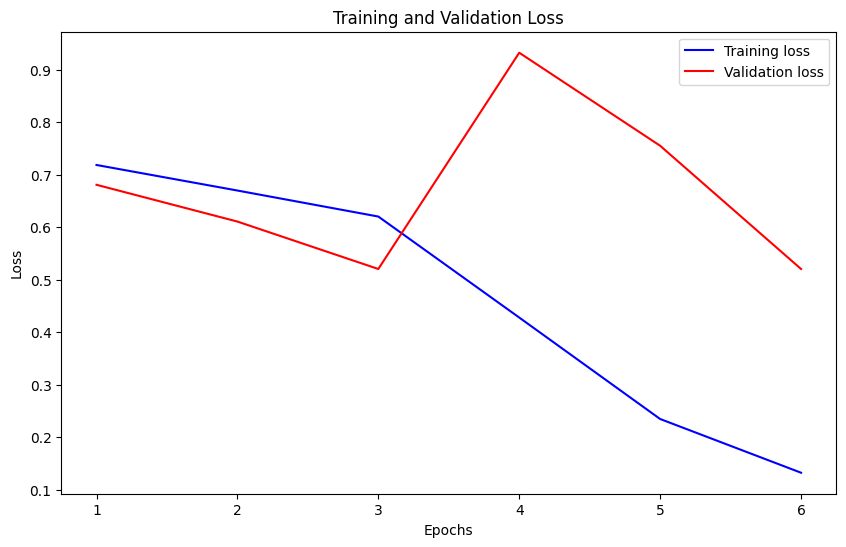

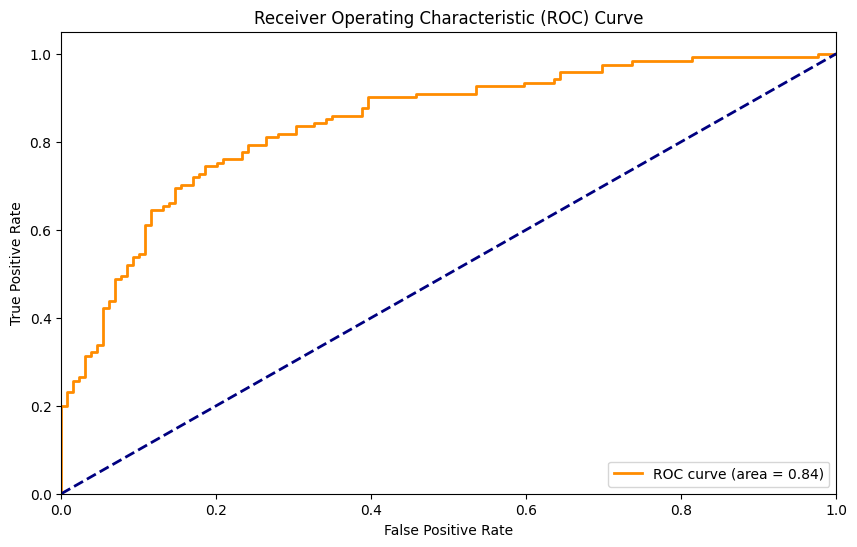

Charts should be displayed above. If not visible, please check your display settings.


In [3]:
# Prevent a Colab timeout
from google.colab import output
output.enable_custom_widget_manager()

# Install necessary packages
!pip install -q transformers[torch] datasets evaluate matplotlib scikit-learn

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
from evaluate import load
from sklearn.metrics import roc_curve, auc

# Load the pre-trained model and tokenizer
model_name = "bert-base-uncased"
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Load the IMDB dataset from Hugging Face and take 1% of it
dataset = load_dataset("imdb")
dataset = dataset.shuffle(seed=42)
dataset['train'] = dataset['train'].select(range(int(len(dataset['train']) * 0.01)))
dataset['test'] = dataset['test'].select(range(int(len(dataset['test']) * 0.01)))
print("1% of IMDB dataset loaded successfully")

# Preprocess the dataset
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True, padding=True, max_length=128)

encoded_dataset = dataset.map(preprocess_function, batched=True)
print("Dataset preprocessed successfully")

# Set the evaluation metric
metric = load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = predictions.argmax(axis=1)
    return metric.compute(predictions=predictions, references=labels)

# Setup the training arguments
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    logging_dir='./logs',
    logging_steps=10,
)

# Split the dataset into train and validation sets
train_dataset = encoded_dataset['train']
eval_dataset = encoded_dataset['test']
print("Using existing train/test split")

# Set up the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# Train the model
print("Starting training ...")
trainer.train()
print("Training completed")

# Evaluate the model
eval_result = trainer.evaluate()
print(f"Evaluation result: {eval_result}")

# Plot training and validation loss
history = trainer.state.log_history
train_loss = [x['loss'] for x in history if 'loss' in x and 'eval_loss' not in x]
val_loss = [x['eval_loss'] for x in history if 'eval_loss' in x]

# Ensure we have the same number of points for both losses
min_len = min(len(train_loss), len(val_loss))
train_loss = train_loss[:min_len]
val_loss = val_loss[:min_len]

epochs = range(1, min_len + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Get predictions for the test set
test_preds = trainer.predict(eval_dataset).predictions
test_labels = eval_dataset['label']

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(test_labels, test_preds[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

print("Charts should be displayed above. If not visible, please check your display settings.")